In [1]:
%%capture
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
df = pd.read_csv('player_info.csv', index_col = [0], encoding = 'utf-8')

### Pre-Processes the Data

In [4]:
# get the height in feet and inches
df[['Height_Feet', 'Height_Inches']] = df['Height'].str.split('-', expand = True)

# split into primary and secondary positions
df[['Primary_Posititon', 'Secondary_Position']] = df['Posititon'].str.split('/', expand = True)

# drop the old columns to avoid confusion
df = df.drop(columns = ['Posititon', 'Height'])

In [5]:
df = df.dropna(subset = ['Strengths', 'Weaknesses'])

In [6]:
# make the player names a list to remove from the final dataset
players = df['Player'].str.split(' ').to_list()
flatten = lambda x: [player for players in x for player in players]
player_names = flatten(players)

In [7]:
# remove all numbers and special characters for the 
# strengths and weaknesses columns
cols = ['Strengths', 'Weaknesses']

# remove the stop words from the data
stop_words = set(stopwords.words('english') + player_names)

# create a snowball stemmer and sentiment analyzer
snowball = SnowballStemmer(language = 'english')
sentiment = SentimentIntensityAnalyzer()

In [8]:
import re

def find_sentiment(df, cols): 
    for col in cols: 
        # remove all numbers from the data
        df[col] = df[col].str.replace('’', '').str.replace('\d+', '')

        # tokenize all of the words
        df['Token' + '_' + col] = df[col].apply(word_tokenize)

        # remove the stop words from the data
        df['Token' + '_' + col] = df['Token' + '_' + col].apply(
            lambda words: [word for word in words if word not in stop_words]
        )

        # stem all of the words, removing (ings, etc..)
        df['Token' + '_' + col] = df['Token' + '_' + col].apply(
            lambda words: [snowball.stem(word) for word in words]
        )

        # score this on a polarity scale
        df[col + '_' + 'Polarity_Score'] = df['Token' + '_' + col].apply(
            lambda words: sum([sentiment.polarity_scores(word)['compound'] for word in words])
        )

        # get the average score for each word
        df[col + '_' + 'Total_Words'] = df['Token' + '_' + col].apply(
            lambda words: len(words)
        )
    
    return df

In [9]:
%%time
df = find_sentiment(df, cols = ['Strengths', 'Weaknesses'])

CPU times: user 7.73 s, sys: 84.6 ms, total: 7.81 s
Wall time: 8.16 s


In [10]:
# remove any records where the total words is less than 50
df = df[(df['Strengths_Total_Words'] > 50) & (df['Weaknesses_Total_Words'] > 50)]

In [11]:
df.head()

,Player,Year,Projected,Score,Weight,Strengths,Weaknesses,Height_Feet,Height_Inches,Primary_Posititon,Secondary_Position,Token_Strengths,Strengths_Polarity_Score,Strengths_Total_Words,Token_Weaknesses,Weaknesses_Polarity_Score,Weaknesses_Total_Words
0,Blake Griffin,2009,1,105,248,"Freak of nature, off the charts athletic spec...",Still not a great shooter. Must become more c...,6,10,Power Forward,None,"[freak, natur, ,, chart, athlet, specimen, typ...",12.6260,271,"[still, great, shooter, ., must, becom, comfor...",5.5690,158
0,James Harden,2009,5,98,222,: Very smooth and crafty wing player … Used hi...,: Ended the season with two very poor performa...,6,5,Shooting Guard,None,"[:, veri, smooth, crafti, wing, player, …, use...",5.4992,168,"[:, end, season, two, poor, perform, ncaa, tou...",1.2764,99
0,Brandon Jennings,2009,22,97,170,An extremely quick and explosive player … Play...,Did not have the season needed to improve his...,6,1,Point Guard,None,"[an, extrem, quick, explos, player, …, play, c...",5.6093,136,"[did, season, need, improv, stock, ,, play, pg...",4.8549,148
0,Hasheem Thabeet,2009,2,97,267,Jim Calhoun called Thabeet “one of the most d...,Post game needs refining. Thabeet has not lea...,7,2,Center,None,"[jim, calhoun, call, “, one, domin, player, hi...",0.8702,163,"[post, game, need, refin, ., learn, keep, ball...",2.5104,132
0,Earl Clark,2009,14,93,226,: Versatile combo forward … A mismatch offensi...,: Was able to get away with a lot at the colle...,6,10,Small Forward,None,"[:, versatil, combo, forward, …, a, mismatch, ...",4.7292,206,"[:, was, abl, get, away, lot, colleg, level, s...",-1.4502,170


### Look At what Positions have the highest and Lowest Scores

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

chart = sns.catplot(
    x = 'Primary_Posititon', y = 'Strengths_Polarity_Score', data = df, kind = 'bar', 
    order = ['Point Guard', 'Shooting Guard', 'Small Forward', 'Power Forward', 'Center'], 
    palette = 'GnBu_d'
)

chart.set_xticklabels(rotation = 90)
chart.fig.set_size_inches(16,8)
plt.show();

<Figure size 1600x800 with 1 Axes>

### Get the Top Players By Year

In [13]:
# get a highest upside value by how high how positive their 
# ranking is
df['Highest_Upside'] = df['Strengths_Polarity_Score'].rank(
    method = 'dense', ascending = False
)

# do the same by year
df['Highest_Upside_Year'] = df.groupby('Year')['Strengths_Polarity_Score'].rank(
    method = 'dense', ascending = False
)

In [14]:
total_data = df.loc[df['Highest_Upside'] <= 15]

def plot_bar(df, **kwargs): 
    bar = sns.catplot( 
        y = 'Strengths_Polarity_Score',
        data = df.sort_values(by = ['Strengths_Polarity_Score', 'Year'], ascending = False),  
        palette = 'GnBu_d',
        **kwargs
    )

    bar.set_xticklabels(rotation = 90)
    bar.fig.set_size_inches(16,8)
    plt.show()

In [15]:
total_data = df.loc[df['Highest_Upside'] <= 15]
year_data = df.loc[df['Highest_Upside_Year'] == 1]

# create a concat for year and player for easy plotting
year_data['Player Year'] = year_data['Player'] + '-' + year_data['Year'].astype(str)

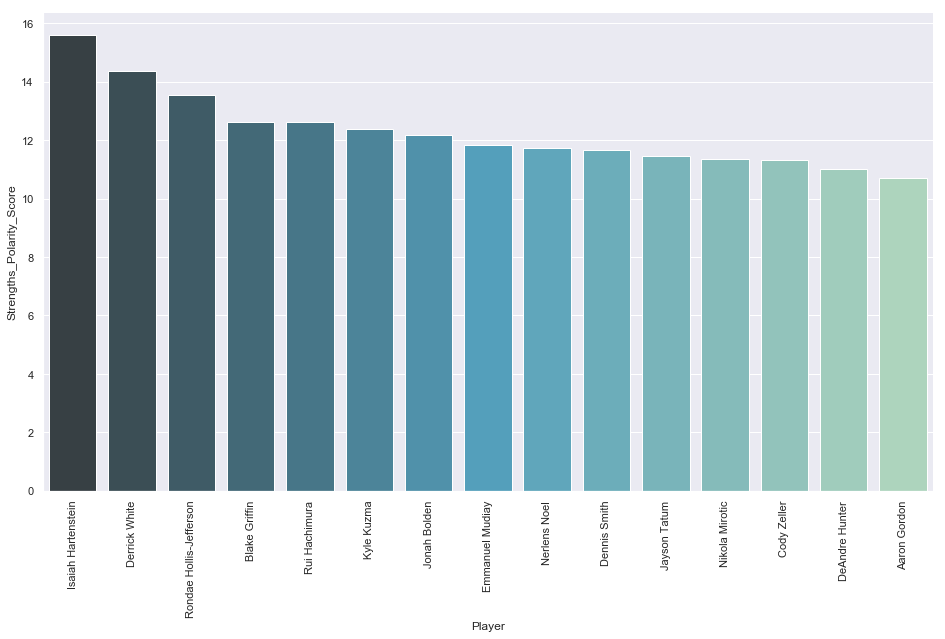

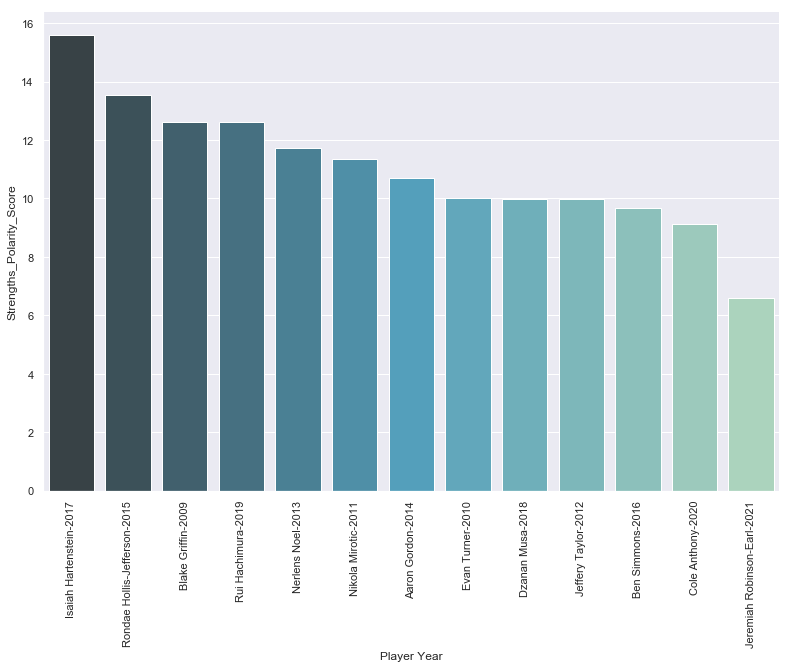

In [16]:
plot_bar(total_data, kind = 'bar', x = 'Player')
plot_bar(year_data, kind = 'bar', x = 'Player Year')

### Get the most important word In the Data

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
def get_tfidf(df, column):
    # initialize the vectorizer
    tfidf = TfidfVectorizer(stop_words = stop_words)
    
    # fit the model and get the importance and weights
    output = tfidf.fit(df[column])
    features = output.get_feature_names()
    weights = list(output.idf_)
    
    # format this in a pandas friendly way
    feat_weight_lkp = {}
    for feature, weight in zip(features, weights): 
        feat_weight_lkp[feature] = weight
        
    features = pd.DataFrame([feat_weight_lkp]).T.reset_index()
    features.columns = ['Word', 'Score']
    
    return features

In [19]:
import warnings
# probabaly not the best idea but works for this instance
warnings.filterwarnings('ignore')

strength_tw = get_tfidf(df, 'Strengths')
weakness_tw = get_tfidf(df, 'Weaknesses')

In [20]:
def plot_word_importance(df):  
    df['Importance'] = df['Score'].rank(method = 'first', ascending = True)
    
    plot = sns.catplot(
        data = df.loc[df['Importance'] <= 10].sort_values(
            by = 'Importance', ascending = False
        ), 
        x = 'Word', 
        y = 'Score', 
        kind = 'bar'
    )
    plot.set_xticklabels(rotation = 90)
    plot.set_xticklabels(fontsize = 20)
    plot.fig.set_size_inches(16,8)
    plt.show()
    

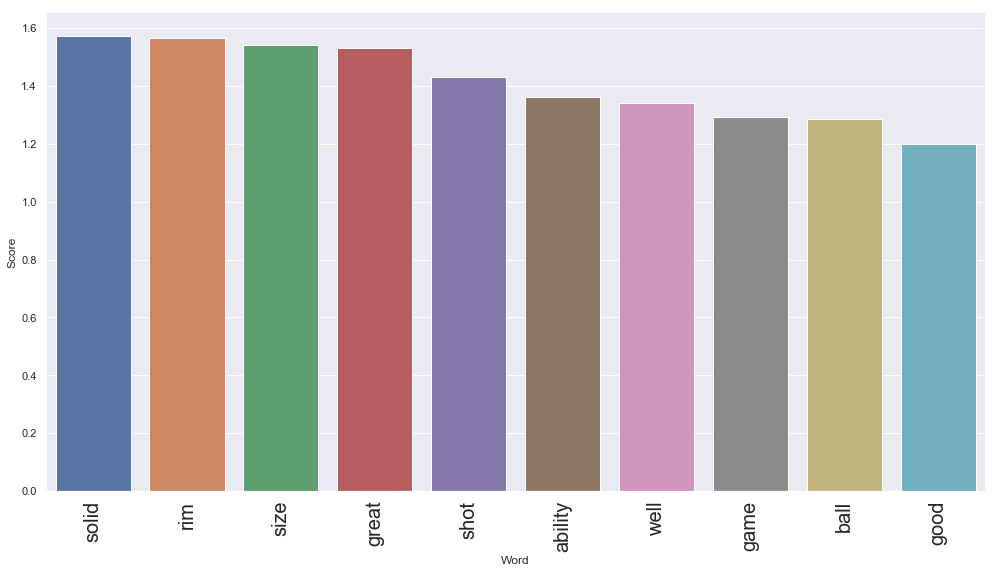

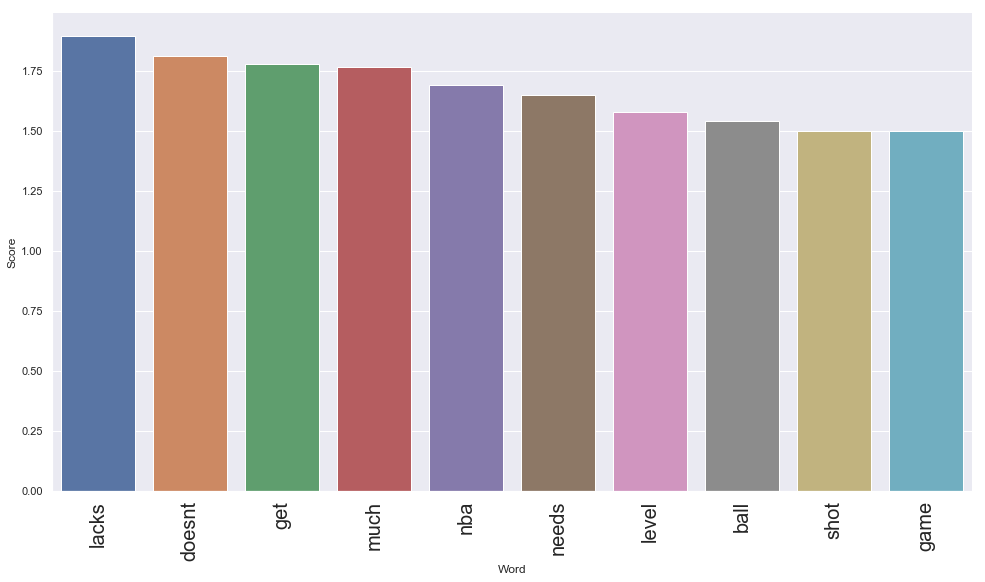

In [21]:
plot_word_importance(strength_tw)
plot_word_importance(weakness_tw)

### Make a Wordcloud as Well

In [25]:
from wordcloud import WordCloud

In [46]:
def generate_wordcloud(df, column): 
    # flatten the text using the previous function
    text = flatten(df[column])
    wordcloud = WordCloud(max_font_size = 40).generate(''.join(text))
    plt.figure(figsize = (18,10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

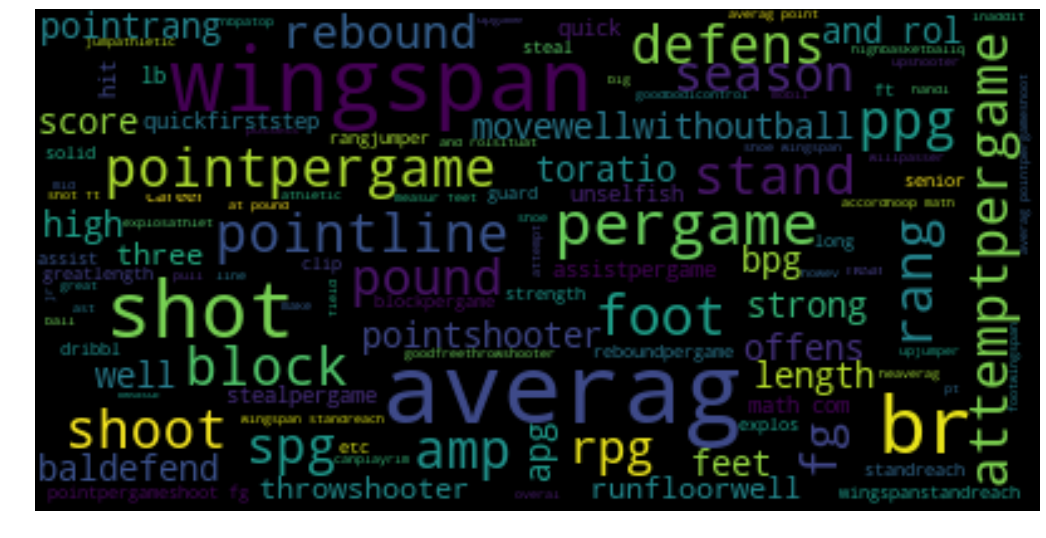

In [49]:
generate_wordcloud(df, 'Token_Strengths')

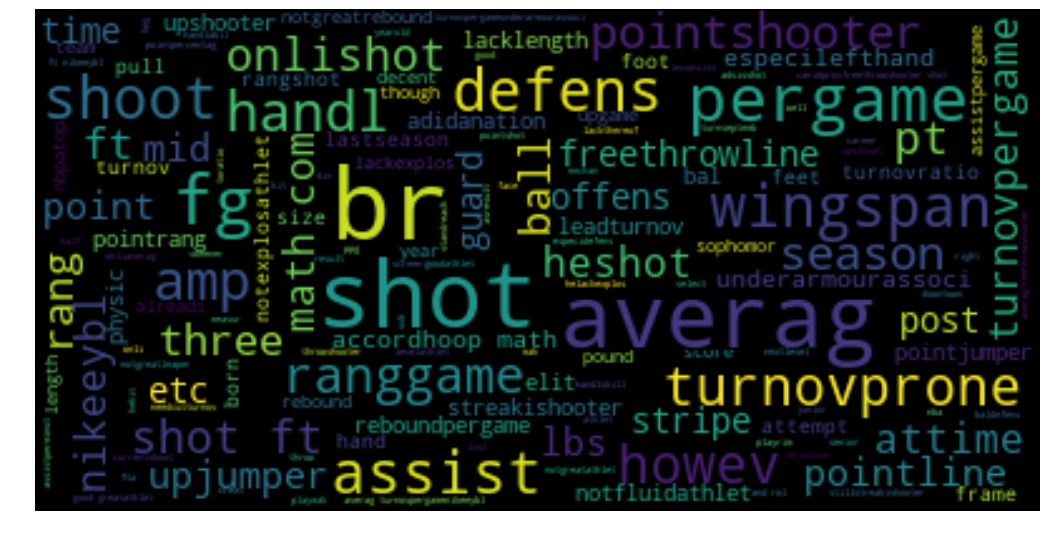

In [50]:
generate_wordcloud(df, 'Token_Weaknesses')